# Team Topic Thunder
CS 410, Fall 2021

# Topic Model Evaluation

Take our base topic model and generate coherence scores for a range of k = number of topics. The initial k is 10. Is this the best topic count?

Next, generate a model with optimal k, and use the pyLDAvis library to visualize topic coverage and overlap.

Finally, output results:
* The dominant topic for each CS 410 project
* The most representative project documentation for each topic

## Step 1: Import Packages and Cleaned Text

Note that this doesn't include code for text preprocessing. That's done as a separate step.

### Ignore deprecation warnings and import required packages

In [21]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import pandas as pd
from ast import literal_eval #to convert file from a string as we are reading from .tsv

import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

### Import cleaned project text, and build a dictionary and document-term matrix

In [7]:
# Import cleaned text
df=pd.read_csv('../project_clean_text.tsv',sep='\t',converters={'clean_text': literal_eval})
df.head()

,project_url,file_text,clean_text
0,https://github.com/17JamesH/CourseProject,project progress report team member task progr...,"[progress, report, member, task, progress, rem..."
1,https://github.com/97agupta/CourseProject,team 'buddie' project proposal 1. what are the...,"[buddie, proposal, name, netids, member, admin..."
2,https://github.com/AShipway/CourseProject,aaron shipway cs 410 fall '21 project progress...,"[aaron, shipway, fall, progress, report, task,..."
3,https://github.com/AlexZurski/CourseProject,alexander zurawski azuraws2 cs 410 11/15/2021 ...,"[alexander, zurawski, azuraws, final, progress..."
4,https://github.com/AnantSharma18/CourseProject,page 1 of 2 project progress report anant ashu...,"[page, progress, report, anant, ashutosh, shar..."


In [90]:
#Creating a mega list of each mega document's cleaned up tokens
megalist=[]
for i in range (len(df)):
    megalist.append(df['clean_text'][i])

In [9]:
# creating a dictionary from the list of lists
dictionary=corpora.Dictionary(megalist)

In [10]:
# Term Document Frequency
doc_term_matrix = [dictionary.doc2bow(doc, allow_update=True) for doc in megalist]

## Step 2: Generate models for range of k = number of topics

Also compute perplexity and coherence scores for each model.

Code copied and adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [44]:
# Routine to generate and score models for a range of k.

def generate_and_score_models(dictionary, corpus, texts, limit, start=2, step=2):
    """
   Generate topic models for a range of topic counts.
   Evaluate coherence for each topic count, and return lists.

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity_values: The log of the perplexity of the corresponding LDA model.
    """
    model_list = []
    coherence_values = []
    log_perplexity_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics, 
                     #random_state=12345,  # For repeatability
                     passes=10,
                     iterations=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        log_perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, log_perplexity_values

In [45]:
# Generate models for the given range of k

start = 2
step = 2
limit = 40

model_list, coherence_values, log_perplexity_values = generate_and_score_models(dictionary=dictionary,
                                                                                corpus=doc_term_matrix,
                                                                                texts=megalist,
                                                                                limit=limit,
                                                                                start=start,
                                                                                step=step)

## Step 3: Review Results

### Review coherence scores

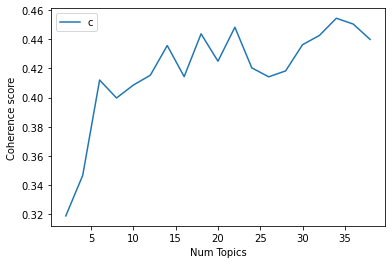

In [46]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, "has Coherence Value of", round(cv, 4))

Num Topics = 2 has Coherence Value of 0.3186
Num Topics = 4 has Coherence Value of 0.3465
Num Topics = 6 has Coherence Value of 0.412
Num Topics = 8 has Coherence Value of 0.3997
Num Topics = 10 has Coherence Value of 0.4086
Num Topics = 12 has Coherence Value of 0.4153
Num Topics = 14 has Coherence Value of 0.4357
Num Topics = 16 has Coherence Value of 0.4144
Num Topics = 18 has Coherence Value of 0.4438
Num Topics = 20 has Coherence Value of 0.425
Num Topics = 22 has Coherence Value of 0.4483
Num Topics = 24 has Coherence Value of 0.4204
Num Topics = 26 has Coherence Value of 0.4142
Num Topics = 28 has Coherence Value of 0.4183
Num Topics = 30 has Coherence Value of 0.4363
Num Topics = 32 has Coherence Value of 0.4427
Num Topics = 34 has Coherence Value of 0.4545
Num Topics = 36 has Coherence Value of 0.4505
Num Topics = 38 has Coherence Value of 0.4399


Coherence shows a local peak at 6 topics, then rises between 10 and 14 topics. Examine those models more closely.

It's common practice to pick the first model that hits peak coherence before plateauing.

### Review log-perplexity scores

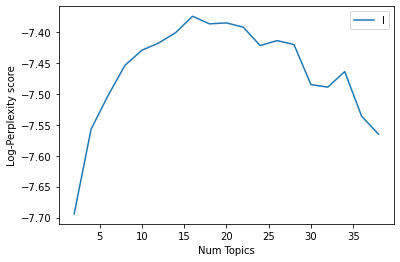

In [49]:
x = range(start, limit, step)
plt.plot(x, log_perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Log-Perplexity score")
plt.legend(("log_perplexity_values"), loc='best')
plt.show()

In [50]:
for m, lpv in zip(x, log_perplexity_values):
    print("Num Topics =", m, "has Log-Perplexity Value of", round(lpv, 4))

Num Topics = 2 has Log-Perplexity Value of -7.6941
Num Topics = 4 has Log-Perplexity Value of -7.5572
Num Topics = 6 has Log-Perplexity Value of -7.5029
Num Topics = 8 has Log-Perplexity Value of -7.454
Num Topics = 10 has Log-Perplexity Value of -7.4295
Num Topics = 12 has Log-Perplexity Value of -7.4177
Num Topics = 14 has Log-Perplexity Value of -7.401
Num Topics = 16 has Log-Perplexity Value of -7.3745
Num Topics = 18 has Log-Perplexity Value of -7.3868
Num Topics = 20 has Log-Perplexity Value of -7.3852
Num Topics = 22 has Log-Perplexity Value of -7.3921
Num Topics = 24 has Log-Perplexity Value of -7.4219
Num Topics = 26 has Log-Perplexity Value of -7.4138
Num Topics = 28 has Log-Perplexity Value of -7.4202
Num Topics = 30 has Log-Perplexity Value of -7.4849
Num Topics = 32 has Log-Perplexity Value of -7.4891
Num Topics = 34 has Log-Perplexity Value of -7.4639
Num Topics = 36 has Log-Perplexity Value of -7.5362
Num Topics = 38 has Log-Perplexity Value of -7.5652


Log-perplexity peaks at 16 topics.

### Examine highlighted topic models

Review the models highlighted by the coherence and log-perplexity scores: 6, 10, 14 and 16 topics.

View the topics themselves, and generate pyLDAvis breakdowns to help gauge topic sizes and degrees of overlap.

#### 6-topic model

* 0: Twitter, sarcasm detection.
  * "mining" isn't directly part of text classification, though. Was it a pre-step? Or leakage from another topic?
* 1: Aspect mining in movie reviews? Usually associated with sentiment analysis, but "sentiment" does not appear
* 2: Seems like a mix. Text retrieval, sentiment analysis, system extension?
* 3: Sentiment associated with stock prices?
* 4: Text classification using BERT
* 5: Topic modeling using faculty websites?

In [51]:
# Show topics for the 6-topic model
pprint(model_list[2].print_topics(num_words=10))

[(0,
  '0.083*"twitter_" + 0.053*"sarcasm" + 0.032*"not_sarcasm" + 0.022*"model" + '
  '0.014*"theme" + 0.013*"collection" + 0.010*"pattern" + 0.010*"text" + '
  '0.008*"context" + 0.007*"mining"'),
 (1,
  '0.020*"model" + 0.016*"review" + 0.011*"aspect" + 0.008*"rating" + '
  '0.008*"movie" + 0.007*"dataset" + 0.007*"result" + 0.005*"analysis" + '
  '0.005*"task" + 0.005*"test"'),
 (2,
  '0.012*"hour" + 0.010*"task" + 0.009*"system" + 0.008*"topic" + '
  '0.008*"search" + 0.008*"sentiment" + 0.008*"page" + 0.007*"text" + '
  '0.007*"extension" + 0.006*"analysis"'),
 (3,
  '0.018*"topic" + 0.011*"time" + 0.010*"stock" + 0.009*"pattern" + '
  '0.008*"model" + 0.007*"sentiment" + 0.006*"series" + 0.005*"set" + '
  '0.005*"context" + 0.005*"word"'),
 (4,
  '0.027*"model" + 0.010*"text" + 0.010*"bert" + 0.009*"test" + '
  '0.009*"classification" + 0.006*"train" + 0.006*"dataset" + 0.005*"set" + '
  '0.005*"result" + 0.005*"response"'),
 (5,
  '0.016*"topic" + 0.011*"document" + 0.011*"mode

pyLDAvis output for the 6-topic model.

Topic 1 is entirely contained within topic 4 (above). Does aspect mining figure into text classification?

Topics 2 and 5 have significant overlap.
* Model 2 looks like a grab bag of topic mining, system extension, text retrieval and sentiment analysis.
* Model 5 looks like it could be related to scraping faculty webpages. Where would ovelap with 2 come from?

Topics 0 and 3 have good separation from the others.

In [66]:
pyLDAvis.enable_notebook()
vis_6_topics = pyLDAvis.gensim_models.prepare(model_list[2], doc_term_matrix, dictionary=model_list[2].id2word)
vis_6_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.091438 -0.076810       1        1  23.306349
4      0.026900  0.103791       2        1  23.029890
5      0.071388 -0.048186       3        1  19.422160
3     -0.005804 -0.036073       4        1  13.965518
0     -0.203808 -0.028265       5        1  12.465498
1      0.019887  0.085542       6        1   7.810586, topic_info=             Term         Freq        Total Category  logprob  loglift
7943     twitter_  3324.000000  3324.000000  Default  30.0000  30.0000
1777      sarcasm  2477.000000  2477.000000  Default  29.0000  29.0000
1751  not_sarcasm  1328.000000  1328.000000  Default  28.0000  28.0000
374         model  4641.000000  4641.000000  Default  27.0000  27.0000
627         theme   710.000000   710.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
94         member    70.118176   898.381302   Topic6  -5.8792  -0.0007
97           need    68.502190   777.791784   Topic6  -5.9025   0.1201
137           set    70.133329  1263.587042   Topic6  -5.8790  -0.3416
263           edu    67.089972   743.491327   Topic6  -5.9234   0.1444
99         number    67.204942   790.240907   Topic6  -5.9217   0.0851

[498 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13304      3  0.966057  __________
8688       3  0.944697     _player
164        4  0.945145        aapl
764        1  0.080158    accuracy
764        2  0.656683    accuracy
...      ...       ...         ...
551        4  0.756245        york
551        5  0.080073        york
1645       1  0.039783         yue
1645       6  0.954785         yue
1646       6  0.916642      ziyuan

[1378 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 6, 4, 1, 2])

#### 8-topic model

In [64]:
# Show topics for the 8-topic model
pprint(model_list[3].print_topics(num_words=10))

[(0,
  '0.010*"model" + 0.009*"sentiment" + 0.006*"analysis" + 0.006*"text" + '
  '0.006*"hour" + 0.006*"review" + 0.006*"task" + 0.005*"dataset" + '
  '0.005*"result" + 0.005*"system"'),
 (1,
  '0.037*"model" + 0.012*"text" + 0.010*"bert" + 0.009*"test" + '
  '0.008*"classification" + 0.007*"collection" + 0.006*"set" + 0.006*"theme" + '
  '0.006*"result" + 0.006*"learning"'),
 (2,
  '0.014*"search" + 0.012*"topic" + 0.012*"faculty" + 0.011*"url" + '
  '0.011*"model" + 0.008*"page" + 0.008*"text" + 0.008*"document" + '
  '0.007*"system" + 0.006*"query"'),
 (3,
  '0.015*"topic" + 0.012*"task" + 0.009*"hour" + 0.008*"system" + '
  '0.007*"extension" + 0.007*"text" + 0.007*"slide" + 0.006*"page" + '
  '0.006*"search" + 0.006*"member"'),
 (4,
  '0.209*"twitter_" + 0.134*"sarcasm" + 0.080*"not_sarcasm" + 0.012*"model" + '
  '0.006*"dataset" + 0.005*"text" + 0.005*"bert" + 0.004*"job" + '
  '0.004*"result" + 0.004*"tweet"'),
 (5,
  '0.022*"topic" + 0.016*"sentiment" + 0.014*"tweet" + 0.013*"

pyLDAvis output for the 8-topic model.

Topics 1, 4, 6 and 7 (above) have good separation. Other topics have large amounts of overlap.

In [65]:
vis_8_topics = pyLDAvis.gensim_models.prepare(model_list[3], doc_term_matrix, dictionary=model_list[3].id2word)
vis_8_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.017631  0.052146       1        1  24.311150
3      0.064074 -0.034447       2        1  18.967582
5      0.053953  0.004735       3        1  15.227741
2      0.065009 -0.045602       4        1  14.856902
7      0.049202  0.140084       5        1   8.352073
0      0.031304  0.017557       6        1   7.418669
6      0.042152 -0.122173       7        1   6.567864
4     -0.288064 -0.012301       8        1   4.298018, topic_info=             Term         Freq        Total Category  logprob  loglift
7943     twitter_  2899.000000  2899.000000  Default  30.0000  30.0000
1777      sarcasm  2209.000000  2209.000000  Default  29.0000  29.0000
1751  not_sarcasm  1166.000000  1166.000000  Default  28.0000  28.0000
2329      pattern   819.000000   819.000000  Default  27.0000  27.0000
1019    sentiment  1165.000000  1165.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
40       detailed    34.914113   388.492737   Topic8  -5.9792   0.7376
105        please    37.472206   635.389564   Topic8  -5.9085   0.3164
351       library    37.246575   714.703191   Topic8  -5.9145   0.1927
1019    sentiment    39.027053  1165.742882   Topic8  -5.8678  -0.2498
242      datasets    33.340523   543.125818   Topic8  -6.0253   0.3564

[624 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13304      4  0.982401  __________
8688       3  0.973758     _player
164        3  0.949727        aapl
764        1  0.488553    accuracy
764        2  0.104470    accuracy
...      ...       ...         ...
11403      1  0.976506      y_pred
1645       2  0.072255         yue
1645       5  0.903189         yue
15526      8  0.872682      zainal
15527      8  0.872769     zainalh

[1972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 3, 8, 1, 7, 5])

#### 10-topic model

In [55]:
# Model with 10 topics
pprint(model_list[4].print_topics(num_words=10))

[(0,
  '0.246*"twitter_" + 0.157*"sarcasm" + 0.094*"not_sarcasm" + 0.011*"model" + '
  '0.005*"bert" + 0.004*"context" + 0.004*"dataset" + 0.004*"sentiment" + '
  '0.004*"result" + 0.003*"evaluation"'),
 (1,
  '0.014*"hour" + 0.009*"model" + 0.008*"task" + 0.008*"page" + '
  '0.007*"algorithm" + 0.007*"query" + 0.007*"document" + 0.006*"ranking" + '
  '0.006*"run" + 0.006*"result"'),
 (2,
  '0.036*"pattern" + 0.018*"context" + 0.015*"frequent" + 0.012*"meta" + '
  '0.010*"metapy" + 0.009*"author" + 0.009*"title" + 0.008*"unit" + '
  '0.007*"transaction" + 0.006*"annotation"'),
 (3,
  '0.023*"sentiment" + 0.021*"topic" + 0.018*"tweet" + 0.015*"stock" + '
  '0.012*"analysis" + 0.011*"time" + 0.010*"twitter" + 0.009*"rating" + '
  '0.006*"system" + 0.006*"word"'),
 (4,
  '0.016*"topic" + 0.014*"search" + 0.010*"system" + 0.009*"task" + '
  '0.008*"faculty" + 0.007*"text" + 0.007*"hour" + 0.007*"page" + 0.007*"url" '
  '+ 0.006*"document"'),
 (5,
  '0.032*"model" + 0.011*"bert" + 0.011*"te

pyLDAvis output for 10 topics.

Most topics have high overlap with several other topics. The exceptions are 0, 2 and 5 (above).

In [60]:
#pyLDAvis.enable_notebook()
vis_10_topics = pyLDAvis.gensim_models.prepare(model_list[4], doc_term_matrix, dictionary=model_list[4].id2word)
vis_10_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.057112 -0.071286       1        1  23.556163
5     -0.029755 -0.077110       2        1  21.485499
1      0.038944 -0.081947       3        1  11.705591
8      0.053501  0.039295       4        1   9.451330
3      0.049970 -0.047386       5        1   9.382334
9      0.056047  0.057365       6        1   6.593049
2      0.055289  0.169722       7        1   6.182698
7      0.010928 -0.071501       8        1   4.301747
0     -0.333816  0.026745       9        1   3.852096
6      0.041780  0.056103      10        1   3.489493, topic_info=             Term         Freq        Total Category  logprob  loglift
7943     twitter_  3053.000000  3053.000000  Default  30.0000  30.0000
1777      sarcasm  2297.000000  2297.000000  Default  29.0000  29.0000
1751  not_sarcasm  1222.000000  1222.000000  Default  28.0000  28.0000
2329      pattern   832.000000   832.000000  Default  27.0000  27.0000
150         topic  2898.000000  2898.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
232        corpus    37.892539   460.764222  Topic10  -5.6889   0.8573
137           set    43.282957  1259.061301  Topic10  -5.5559  -0.0149
125        result    42.728631  1700.356046  Topic10  -5.5688  -0.3283
503          step    37.116528   732.399360  Topic10  -5.7096   0.3732
94         member    37.227045   893.302654  Topic10  -5.7067   0.1775

[767 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13304      1  0.978932  __________
8688       2  0.952112     _player
164        5  0.864794        aapl
164        6  0.103775        aapl
11195      8  0.900189         acc
...      ...       ...         ...
551        6  0.534047        york
551        7  0.043774        york
551       10  0.078794        york
15526      9  0.835734      zainal
15527      9  0.835753     zainalh

[2434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 9, 4, 10, 3, 8, 1, 7])

#### 14-topic model

This has the highest coherence score at the beginning of a plateau.

In [57]:
# Model with 14 topics
pprint(model_list[6].print_topics(num_words=10))

[(0,
  '0.014*"system" + 0.012*"page" + 0.011*"search" + 0.010*"faculty" + '
  '0.010*"url" + 0.009*"topic" + 0.009*"hour" + 0.008*"task" + 0.007*"text" + '
  '0.007*"slide"'),
 (1,
  '0.019*"model" + 0.017*"document" + 0.010*"run" + 0.008*"script" + '
  '0.008*"ranking" + 0.008*"test" + 0.007*"text" + 0.007*"algorithm" + '
  '0.007*"dataset" + 0.007*"query"'),
 (2,
  '0.016*"tweet" + 0.013*"topic" + 0.009*"run" + 0.009*"time" + 0.007*"word" + '
  '0.007*"player" + 0.007*"game" + 0.006*"sentiment" + 0.005*"language" + '
  '0.005*"dataset"'),
 (3,
  '0.013*"task" + 0.013*"hour" + 0.012*"topic" + 0.010*"model" + '
  '0.009*"sentiment" + 0.008*"extension" + 0.007*"time" + 0.007*"text" + '
  '0.007*"news" + 0.007*"member"'),
 (4,
  '0.305*"twitter_" + 0.197*"sarcasm" + 0.118*"not_sarcasm" + 0.013*"model" + '
  '0.007*"bert" + 0.005*"dataset" + 0.004*"sentiment" + 0.004*"context" + '
  '0.004*"evaluation" + 0.004*"response"'),
 (5,
  '0.018*"sentiment" + 0.016*"analysis" + 0.013*"tweet" + 0

pyLDAvis output for 14 topics

Only topics 4, 8 and 10 (above) have good separation from other models. Remaining topics have very high overlap.

In [62]:
vis_14_topics = pyLDAvis.gensim_models.prepare(model_list[6], doc_term_matrix, dictionary=model_list[6].id2word)
vis_14_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.018441  0.002331       1        1  23.134500
0      0.087729  0.063224       2        1  15.517914
3      0.066727  0.046545       3        1  12.480419
8      0.036137 -0.170026       4        1   8.229278
5      0.053989  0.030107       5        1   7.827492
1     -0.013830 -0.003287       6        1   6.557873
7      0.065381  0.070459       7        1   6.469384
9      0.056696  0.067046       8        1   5.597680
10     0.014807 -0.243776       9        1   3.777378
2      0.037710  0.018386      10        1   3.657480
4     -0.384370  0.020377      11        1   3.283861
11     0.041803  0.010947      12        1   1.582903
12     0.007242  0.038568      13        1   1.566756
13    -0.051581  0.049098      14        1   0.317082, topic_info=             Term         Freq        Total Category  logprob  loglift
7943     twitter_  3218.000000  3218.000000  Default  30.0000  30.0000
1777      sarcasm  2399.000000  2399.000000  Default  29.0000  29.0000
1751  not_sarcasm  1284.000000  1284.000000  Default  28.0000  28.0000
2329      pattern   865.000000   865.000000  Default  27.0000  27.0000
827       context  1089.000000  1089.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
607         query     2.608498   795.666446  Topic14  -5.9666   0.0334
125        result     2.735842  1700.740083  Topic14  -5.9189  -0.6786
1751  not_sarcasm     2.562644  1284.619037  Topic14  -5.9843  -0.4634
150         topic     2.596079  2865.991863  Topic14  -5.9713  -1.2529
146          text     2.354111  2450.708891  Topic14  -6.0692  -1.1942

[1036 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
13304      1  0.966691    __________
8686      10  0.837348           _bm
8688      10  0.933102       _player
11195      6  0.914275           acc
12976     11  0.749529  accommodaaon
...      ...       ...           ...
15527     11  0.803921       zainalh
15452      5  0.901330       zhengyu
1646       3  0.856807        ziyuan
1646      11  0.077892        ziyuan
14510      8  0.890760          zlib

[3649 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 9, 6, 2, 8, 10, 11, 3, 5, 12, 13, 14])

#### 16-topic model

The model with 16 topics has the highest log-perplexity score. Review that model's topics.

In [58]:
# Model with 16 topics
pprint(model_list[7].print_topics(num_words=10))

[(0,
  '0.308*"twitter_" + 0.198*"sarcasm" + 0.119*"not_sarcasm" + 0.013*"model" + '
  '0.007*"bert" + 0.005*"dataset" + 0.004*"context" + 0.004*"evaluation" + '
  '0.004*"sentiment" + 0.004*"response"'),
 (1,
  '0.017*"recipe" + 0.010*"topic" + 0.008*"docker" + 0.008*"csv" + '
  '0.008*"metapy" + 0.007*"search" + 0.007*"document" + 0.007*"positive" + '
  '0.006*"patient" + 0.006*"re"'),
 (2,
  '0.033*"model" + 0.014*"bert" + 0.011*"text" + 0.009*"classification" + '
  '0.008*"run" + 0.008*"test" + 0.007*"learning" + 0.007*"context" + '
  '0.007*"competition" + 0.006*"train"'),
 (3,
  '0.047*"pattern" + 0.021*"context" + 0.018*"frequent" + 0.015*"author" + '
  '0.015*"title" + 0.009*"unit" + 0.008*"transaction" + 0.007*"dataset" + '
  '0.007*"information" + 0.007*"dblp"'),
 (4,
  '0.028*"model" + 0.015*"test" + 0.008*"build" + 0.007*"text" + '
  '0.007*"dataset" + 0.007*"meta" + 0.006*"feature" + 0.006*"train" + '
  '0.005*"label" + 0.005*"vector"'),
 (5,
  '0.027*"tweet" + 0.022*"sent

pyLDAvis output for 16 topics

In [61]:
vis_16_topics = pyLDAvis.gensim_models.prepare(model_list[7], doc_term_matrix, dictionary=model_list[7].id2word)
vis_16_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.037801  0.051552       1        1  17.363070
10     0.088970  0.107295       2        1  12.772606
15     0.075461  0.062219       3        1  12.750634
5      0.059032  0.063593       4        1   7.899701
8      0.047424 -0.066311       5        1   7.593947
4     -0.031674  0.061308       6        1   7.228369
7      0.067211  0.044252       7        1   6.032753
11     0.035423 -0.102890       8        1   5.981439
6      0.058195  0.093929       9        1   5.627145
3      0.039527 -0.103393      10        1   4.966101
0     -0.387039  0.068658      11        1   3.301476
12     0.034829 -0.001773      12        1   3.230891
1      0.041151  0.041908      13        1   3.149923
14    -0.019978 -0.111388      14        1   1.036074
13     0.004526 -0.059020      15        1   0.920387
9     -0.075256 -0.149938      16        1   0.145485, topic_info=             Term         Freq        Total Category  logprob  loglift
7943     twitter_  3276.000000  3276.000000  Default  30.0000  30.0000
1777      sarcasm  2444.000000  2444.000000  Default  29.0000  29.0000
1751  not_sarcasm  1308.000000  1308.000000  Default  28.0000  28.0000
2329      pattern   827.000000   827.000000  Default  27.0000  27.0000
1066        tweet  1089.000000  1089.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
516          test     1.407687  1448.460809  Topic16  -5.8043  -0.4035
127           run     1.388680  1314.728730  Topic16  -5.8179  -0.3202
371        method     1.306602   634.830086  Topic16  -5.8788   0.3469
36        dataset     1.338774  1541.137524  Topic16  -5.8545  -0.5157
1476          txt     1.288847   602.766379  Topic16  -5.8925   0.3851

[1187 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
13304      2  0.971118   __________
8344      11  0.835979        _part
7054      10  0.846195  _with_index
5474      15  0.793294        aarch
5722       1  0.945110     abhishek
...      ...       ...          ...
2771      12  0.804950       yutong
13355      2  0.917857     zacharia
15526     11  0.792398       zainal
15527     11  0.792482      zainalh
1646       7  0.917298       ziyuan

[4486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 11, 16, 6, 9, 5, 8, 12, 7, 4, 1, 13, 2, 15, 14, 10])

## Step 4: Choose Optimal Model and Output Its Document/Topic Relationships

The 6-topic model shows the greatest degree of topic separation in the pyLDAvis output. However, the 14-topic model reaches a high coherence value before a plateau of coherence scores.

Use the 6-topic model for illustration.

In [67]:
optimal_model = model_list[2]

Identify the dominant topic in each CS 410 project.

Once again, code borrowed from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [79]:
def format_topics_docs(ldamodel, corpus, texts):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


df_topic_docs_keywords = format_topics_docs(ldamodel=optimal_model, corpus=doc_term_matrix, texts=megalist)

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

# Show
df_dominant_topic.head(10)

,document_no,dominant_topic,topic_perc_contrib,keywords,text
0,0,2.0,0.9980,"hour, task, system, topic, search, sentiment, ...","[progress, report, member, task, progress, rem..."
1,1,3.0,0.8926,"topic, time, stock, pattern, model, sentiment,...","[buddie, proposal, name, netids, member, admin..."
2,2,2.0,0.6240,"hour, task, system, topic, search, sentiment, ...","[aaron, shipway, fall, progress, report, task,..."
3,3,2.0,0.9912,"hour, task, system, topic, search, sentiment, ...","[alexander, zurawski, azuraws, final, progress..."
4,4,4.0,0.9944,"model, text, bert, test, classification, train...","[page, progress, report, anant, ashutosh, shar..."
5,5,2.0,0.8807,"hour, task, system, topic, search, sentiment, ...","[please, paste, cmt, detailed, instruction, ac..."
6,6,2.0,0.7540,"hour, task, system, topic, search, sentiment, ...","[reddit, recommenders, task, completed, divide..."
7,7,2.0,0.9003,"hour, task, system, topic, search, sentiment, ...","[proposal, song, retrieval, sentiment, analysi..."
8,8,5.0,0.5197,"topic, document, model, faculty, search, query...","[progress, report, andrew, sciotti, sciotti, t..."
9,9,2.0,0.9958,"hour, task, system, topic, search, sentiment, ...","[task, completed, frontend, completed, created..."


Output dominant topic for each document, both as standalone table and combined with original document dataframe.

In [81]:
# Output dominant topics
df_dominant_topic.to_csv("./Optimal_Model_Dom_Topic_Per_Doc.tsv", sep="\t", index=False)

In [82]:
# Merge list of dominant topics with original list of CS 410 project URLs and text.
df_project_dominant_topic = df.join(df_dominant_topic, how="inner")

In [89]:
# Output combined dataframe.
df_project_dominant_topic[["document_no", "project_url", "dominant_topic", "topic_perc_contrib", "keywords", "text"]].to_csv("./Optimal_Model_Dom_Topic_Doc_Output.tsv", sep="\t", index=False)

Display the most representative document for each topic.

In [86]:
doc_topics_sorted_df = pd.DataFrame()

doc_topics_grouped = df_topic_docs_keywords.groupby('dominant_topic')

for i, grp in doc_topics_grouped:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index
doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorted_df.columns = ['topic_num', "topic_perc_contrib", "keywords", "text"]

# Show
doc_topics_sorted_df.head(len(doc_topics_sorted_df))

,topic_num,topic_perc_contrib,keywords,text
0,0.0,0.9999,"twitter_, sarcasm, not_sarcasm, model, theme, ...","[progress, report, topic, bert, sentiment, ana..."
1,1.0,0.9996,"model, review, aspect, rating, movie, dataset,...","[fall, progress, report, author, thiago, seuac..."
2,2.0,0.9996,"hour, task, system, topic, search, sentiment, ...","[thursday, december, final, report, daniel, ch..."
3,3.0,0.9998,"topic, time, stock, pattern, model, sentiment,...","[mining, causal, topic, text, iterative, topic..."
4,4.0,0.9998,"model, text, bert, test, classification, train...","[text, information, system, final, final, repo..."
5,5.0,0.9999,"topic, document, model, faculty, search, query...","[improving, expertsearch, progress, report, pl..."


In [87]:
# Output the most representative doc for each topic.
doc_topics_sorted_df.to_csv("./Optimal_Model_Rep_Doc_Per_Topic.tsv", sep="\t", index=False)

# Conclusion

The three evaluation measures -- coherence, perplexity, and topic overlap shown in pyLDAvis -- all recommend different values for k = number of topics.

This may have to do with the "documents" themselves. Each project is a heterogenous collection of textual files, and we may be losing precision to group them together.

Potential measures could include:
* Excluding additional high-usage words that aren't topic-specific, like "data", "progress", "report" and "result"
* Finding a way to weight text from the overview section of each project. This is more likely to have what we want, when it exists.